In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
import numpy as np
import pandas as pd
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc

from sklearn.metrics import adjusted_rand_score
from IPython.display import display, HTML

import warnings
from numba.core.errors import NumbaDeprecationWarning

from calicost import arg_parse

In [3]:
from sim_analysis import (
    get_config,
    get_sampleid,
    get_best_r_hmrf,
    get_rdrbaf,
    get_true_clones_path,
    get_true_clones,
    get_sim_runs,
    get_numbat_path,
    get_numbat_clones,
    get_starch_clones,
    plot_true_clones,
    get_calico_clones,
    read_gene_loc,
    read_true_gene_cna,
    read_calico_gene_cna,
    read_numbat_gene_cna,
    read_starch_gene_cna,
    compute_gene_F1,
    get_aris, 
    plot_aris,
    get_f1s,
    plot_f1s,
    plot_calico_clones
)

## Configuration

In [4]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [5]:
pd.set_option('display.max_rows', 10)
plt.rcParams.update({'font.size': 14})
sc.set_figure_params(dpi=120)

In [6]:
! pwd

/Users/mw9568/Work/ragr/sim/calicost_sim


In [7]:
true_dir = "../simulated_data_related"
calico_pure_dir = "../nomixing_calicost_related"
numbat_dir = "../numbat_related"
starch_dir = "../starch_related"

# hg_table_file = "/nfs/turbo/umms-congma1/projects/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"
hg_table_file = "/Users/mw9568/Work/ragr/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"

## Preface

Note:
 - min. 100 spots per clone
 - assumes (max.) of 3 clones

### Available Runs

In [8]:
sim_runs = get_sim_runs()
sim_runs

,n_cnas,cna_size,ploidy,random,sampleid
0,"(1, 2)",1e7,2,0,numcnas1.2_cnasize1e7_ploidy2_random0
1,"(1, 2)",1e7,2,1,numcnas1.2_cnasize1e7_ploidy2_random1
2,"(1, 2)",1e7,2,2,numcnas1.2_cnasize1e7_ploidy2_random2
3,"(1, 2)",1e7,2,3,numcnas1.2_cnasize1e7_ploidy2_random3
4,"(1, 2)",1e7,2,4,numcnas1.2_cnasize1e7_ploidy2_random4
...,...,...,...,...,...
85,"(6, 3)",5e7,2,5,numcnas6.3_cnasize5e7_ploidy2_random5
86,"(6, 3)",5e7,2,6,numcnas6.3_cnasize5e7_ploidy2_random6
87,"(6, 3)",5e7,2,7,numcnas6.3_cnasize5e7_ploidy2_random7
88,"(6, 3)",5e7,2,8,numcnas6.3_cnasize5e7_ploidy2_random8


### Config for a given run

In [9]:
config_path = "../nomixing_calicost_related//numcnas1.2_cnasize1e7_ploidy2_random0/configfile0"

config = get_config(config_path)
pprint.pprint(config)

{'bafonly': False,
 'construct_adjacency_method': 'hexagon',
 'construct_adjacency_w': 1.0,
 'filtergenelist_file': '/n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/ig_gene_list.txt',
 'filterregion_file': '/n/fs/ragr-data/users/congma/references/cellranger_refdata-gex-GRCh38-2020-A/genes/HLA_regions.bed',
 'fix_BB_dispersion': False,
 'fix_NB_dispersion': False,
 'geneticmap_file': '/u/congma/ragr-data/users/congma/Codes/CalicoST/resources/genetic_map_GRCh38_merged.tab',
 'gmm_random_state': 0,
 'hgtable_file': '/u/congma/ragr-data/users/congma/Codes/STARCH_crazydev/hgTables_hg38_gencode.txt',
 'initialization_method': 'rectangle',
 'logphase_shift': -2.0,
 'max_iter': 30,
 'max_iter_outer': 20,
 'maxspots_pooling': 19,
 'min_avgumi_per_clone': 10,
 'min_percent_expressed_spots': 0.005,
 'min_snpumi_perspot': 50,
 'min_spots_per_clone': 100,
 'n_clones': 3,
 'n_clones_rdr': 2,
 'n_states': 7,
 'nodepotential': 'weighted_sum',
 'nonbalance_bafdist': 1

In [10]:
rdrbaf = get_rdrbaf(config_path, 3, relative_path="../nomixing_calicost_related/", verbose=False)

# NB (# states x # clones TBC).
rdrbaf["new_log_mu"].shape, rdrbaf["new_alphas"].shape, rdrbaf["new_p_binom"].shape, rdrbaf['log_gamma'].shape, rdrbaf['total_llf']

((7, 2), (7, 2), (7, 2), (7, 1750, 2), array(-7479449.7554682))

/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:418: UserWarning: The palette list has more values (20) than needed (4), which may not be intended.
  sns.scatterplot(
/Users/mw9568/Work/ragr/sim/calicost_sim/sim_analysis.py:499: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(


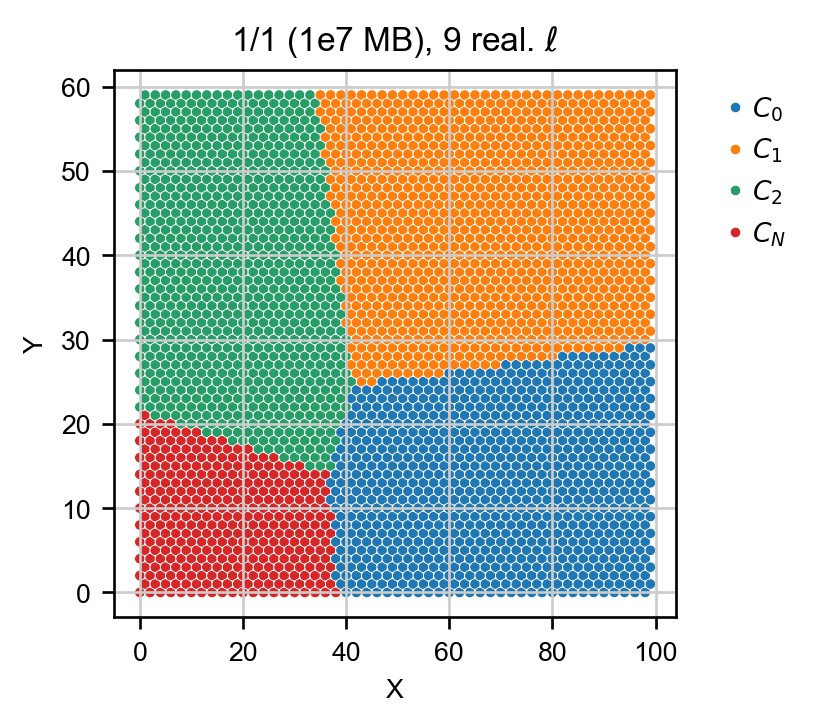

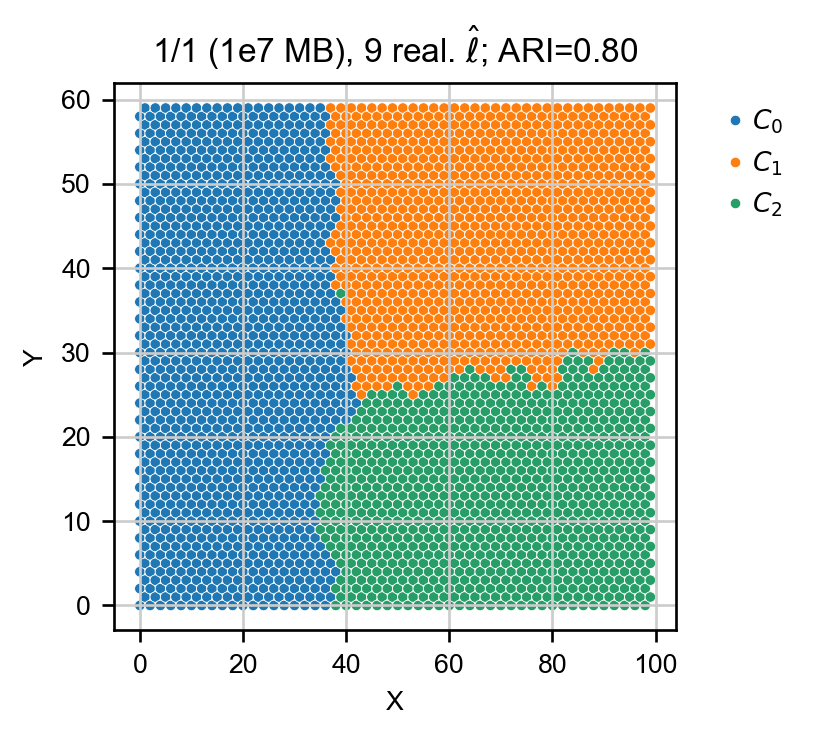

In [11]:
random_state = 9

# state = [(3, 3), "3e7", 2, random_state]
state = [(1, 2), "1e7", 2, random_state]

true = plot_true_clones(true_dir, *state)
est = plot_calico_clones(calico_pure_dir, *state, true_dir)

# Clone identification accuracy

In [12]:
calico_clones = get_calico_clones(calico_pure_dir, *state, true_dir=true_dir)
calico_clones

,est_clone,true_clone,x,y
spot,,,,
0,0,normal,0,0
1,0,normal,0,2
2,0,normal,0,4
3,0,normal,0,6
4,0,normal,0,8
...,...,...,...,...
2995,1,1,99,51
2996,1,1,99,53
2997,1,1,99,55


In [13]:
starch_clones = get_starch_clones(starch_dir, get_sampleid((3, 3), "3e7", 2, 0), true_clones=true_clones)
starch_clones

NameError: name 'true_clones' is not defined

In [ ]:
clone_aris = get_aris(true_dir, calico_pure_dir, numbat_dir, starch_dir)
clone_aris

In [ ]:
plot_aris(clone_aris)

# Event detection accuracy

The detection accuracy is evalated on a per-gene level:
the precision & sensitivity of genes involved in each category of event (Deletion, Amplication, LOH) for all events.

In [ ]:
# NB (chr, start, end) for a given gene list.
df_hgtable = read_gene_loc(hg_table_file)
df_hgtable

In [ ]:
df_event_f1 = get_f1s(true_dir, df_hgtable, calico_pure_dir, numbat_dir, starch_dir)
df_event_f1

In [ ]:
plot_f1s(df_event_f1)

# Done.